## Average Citizens. ETH Analysis

In [1]:
from math import log10

from config import PROJECT_ID, ETH_ANALYSIS_DATASET_NAME, INITIAL_TS, SNAPSHOT_TS, \
    ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME
from src.utils import drop_table, create_table, get_df
from src.utils_charts import grade_boundaries_analysis

DROP_TABLES = True
CREATE_TABLES = True

### Distribution Rule
<table style="text-align: center">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> ETH balance > 0.01 ETH and Amount of outgoing tx</td>
            <td> > 3 tx </td>
            <td> > 61 tx </td>
            <td> > 236 tx </td>
        </tr>
        <tr>
            <td style="text-align: left">OR ETH balance</td>
            <td> > 1 ETH</td>
            <td> > 35 ETH</td>
            <td> > 167 ETH</td>
        </tr>
    </tbody>
</table>

In [2]:
min_eth_balance = 0.01
boundary_outgoing_tx = [3, 61, 236]
boundary_eth_balance = [1, 35, 167]

### ETH Balances

In [3]:
query_1 = f'''
        WITH double_entry_book AS (
            -- debits
            SELECT
                to_address AS address,
                value as value
            FROM `bigquery-public-data.crypto_ethereum.traces`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
              AND to_address is not null
              AND status = 1
              AND (call_type not in ('delegatecall', 'callcode', 'staticcall') OR call_type is null)
            UNION ALL
            -- credits
            SELECT
                from_address AS address,
                -value AS value
            FROM `bigquery-public-data.crypto_ethereum.traces`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
              AND from_address is not null
              AND status = 1
              AND (call_type not in ('delegatecall', 'callcode', 'staticcall') OR call_type is null)
            UNION ALL
            -- transaction fees debits
            SELECT
                miner AS address,
                sum(cast(receipt_gas_used AS numeric) * cast(gas_price AS numeric)) AS value
            FROM `bigquery-public-data.crypto_ethereum.transactions` AS transactions
            JOIN `bigquery-public-data.crypto_ethereum.blocks` AS blocks ON blocks.number = transactions.block_number
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
            GROUP BY blocks.miner
            UNION ALL
            -- transaction fees credits
            SELECT
                from_address AS address,
                -(cast(receipt_gas_used AS numeric) * cast(gas_price AS numeric)) AS value
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
        ),
        outgoing_transactions AS (
            SELECT
                from_address as address,
                count(`hash`) as number_outgoing_transactions
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
            GROUP BY from_address
        )
        SELECT
            CASE
                WHEN eth_balance > {boundary_eth_balance[2]} AND number_outgoing_transactions > {boundary_outgoing_tx[2]} THEN 'ETH Balance  and Amount of Outgoing Transactions'
                WHEN eth_balance > {boundary_eth_balance[2]} THEN 'ETH Balance'
                WHEN number_outgoing_transactions > {boundary_outgoing_tx[2]} THEN 'Amount of Outgoing Transactions'
                WHEN eth_balance > {boundary_eth_balance[1]} AND number_outgoing_transactions > {boundary_outgoing_tx[1]} THEN 'ETH Balance  and Amount of Outgoing Transactions'
                WHEN eth_balance > {boundary_eth_balance[1]} THEN 'ETH Balance'
                WHEN number_outgoing_transactions > {boundary_outgoing_tx[1]}  THEN 'Amount of Outgoing Transactions'
                WHEN eth_balance > {boundary_eth_balance[0]} AND number_outgoing_transactions > {boundary_outgoing_tx[0]} THEN 'ETH Balance  and Amount of Outgoing Transactions'
                WHEN eth_balance > {boundary_eth_balance[0]} THEN 'ETH Balance'
                WHEN number_outgoing_transactions > {boundary_outgoing_tx[0]} THEN 'Amount of Outgoing Transactions'
                ELSE null
            END
            AS subtype,
            CASE
                WHEN eth_balance > {boundary_eth_balance[2]} OR number_outgoing_transactions > {boundary_outgoing_tx[2]} THEN 3
                WHEN eth_balance > {boundary_eth_balance[1]} OR number_outgoing_transactions > {boundary_outgoing_tx[1]} THEN 2
                WHEN eth_balance > {boundary_eth_balance[0]} OR number_outgoing_transactions > {boundary_outgoing_tx[0]} THEN 1
                ELSE null
            END
            AS grade,
            address,
            eth_balance,
            number_outgoing_transactions
        FROM (
            SELECT
                address,
                eth_balance,
                number_outgoing_transactions
            FROM (
                SELECT
                    address,
                    sum(value)/1e18  AS eth_balance
                FROM double_entry_book
                GROUP BY address
                HAVING eth_balance > {min_eth_balance})
            JOIN outgoing_transactions USING (address)
            )
'''

if DROP_TABLES:
    drop_table(table_name=ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ETH_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_1,
                 table_name=ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME,
                 dataset_name=ETH_ANALYSIS_DATASET_NAME)

Table eth_analysis:eth_analysis_distribution has not been deleted.
404 DELETE https://bigquery.googleapis.com/bigquery/v2/projects/cosmic-keep-223223/datasets/eth_analysis/tables/eth_analysis_distribution?prettyPrint=false: Not found: Table cosmic-keep-223223:eth_analysis.eth_analysis_distribution
Table eth_analysis:eth_analysis_distribution has been created and filled 9180232 rows.


### Analysis of Grade Boundaries. Amount of Outgoing Transactions

In [4]:
query_2 = f'''
    SELECT
        number_outgoing_transactions,
        count(address) as number_of_addresses
    FROM `{PROJECT_ID}.{ETH_ANALYSIS_DATASET_NAME}.{ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
    WHERE eth_balance > {min_eth_balance}
    GROUP BY number_outgoing_transactions
'''
distribution_by_outgoing_tx_count_df = get_df(query_2)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,3 < Amount of Outgoing Transactions <= 61,3747483,88.9
2,61 < Amount of Outgoing Transactions <= 236,339847,8.1
3,236 < Amount of Outgoing Transactions,126562,3.0


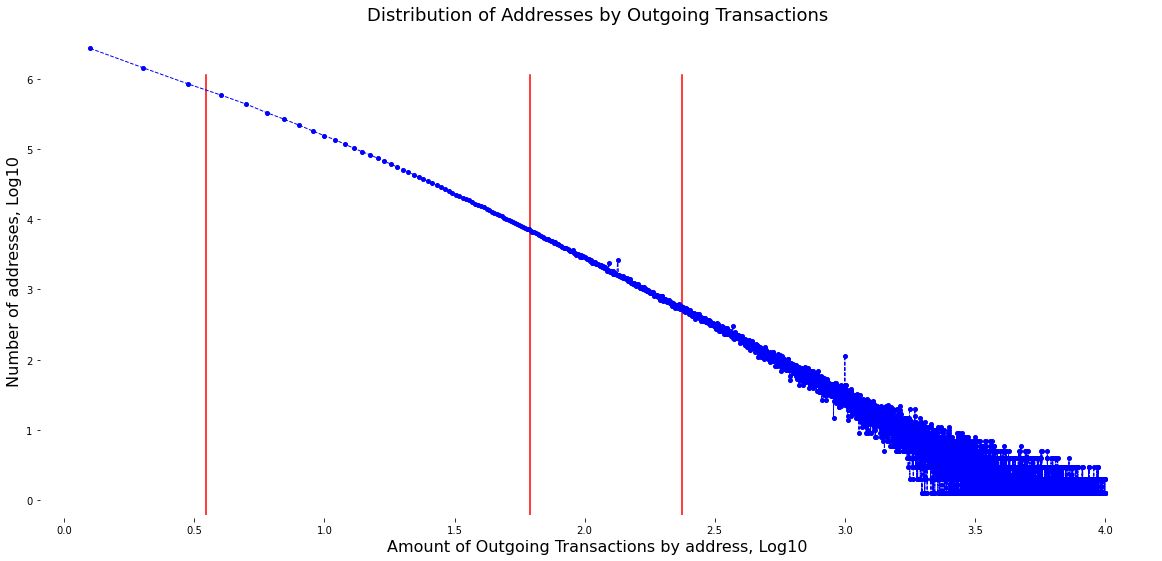

[3, 61, 236]

In [5]:
grade_boundaries_analysis(
    distribution_by_outgoing_tx_count_df,
    value_column = 'number_outgoing_transactions',
    value_chart_label = 'Amount of Outgoing Transactions by address, Log10',
    value_name = 'Amount of Outgoing Transactions',
    chart_title = 'Distribution of Addresses by Outgoing Transactions',
    initial_boundary=3,
    max_show_value=10000)

### Analysis of Grade Boundaries. ETH balance

In [6]:
query_3 = f'''
    SELECT
        ROUND(eth_balance, 1) as eth_balance_class,
        count(address) as number_of_addresses
    FROM `{PROJECT_ID}.{ETH_ANALYSIS_DATASET_NAME}.{ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
    GROUP BY eth_balance_class
    HAVING eth_balance_class > 0
'''
distribution_by_eth_balance_df = get_df(query_3)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,1.0 < ETH Balance <= 35,540084,89.1
2,35 < ETH Balance <= 167,47836,7.9
3,167 < ETH Balance,18198,3.0


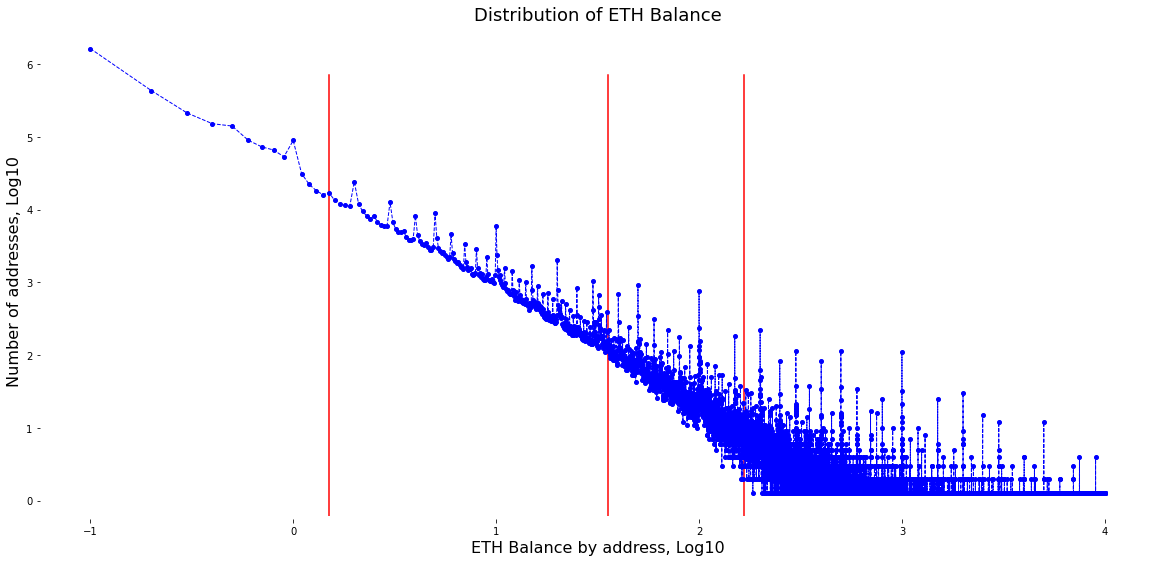

[1.0, 35, 167]

In [7]:
grade_boundaries_analysis(
    distribution_by_eth_balance_df,
    value_column = 'eth_balance_class',
    value_chart_label = 'ETH Balance by address, Log10',
    value_name = 'ETH Balance',
    value_transform_func=lambda x: log10(x),
    chart_title = 'Distribution of ETH Balance',
    initial_boundary=1.0,
    max_show_value=10000)